In [116]:
! pip install openpyxl datetime pandas matplotlib

In [117]:
import os
from openpyxl import Workbook
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [118]:
user_input = '/Users/atharvchandratre/Workspace/Atharv/GitHub/PrismBenchmarkAnalyzer/prism_n3_le20_d202_vchain_2.log' # Enter path to log here
assert os.path.exists(user_input), "I did not find the file at "+str(user_input)
f = open(user_input,'r')
print("Log File found, beginning analysis...")
f.close()

Log File found, beginning analysis...


In [119]:
ProposerBlockMined = 'ProposerBlockMined'
ValidProposerBlockDownloaded = 'ValidProposerBlockDownloaded'
ProposerBlockConfirmed = 'ProposerBlockConfirmed'
ProposerBlockRolledBack = 'ProposerBlockRolledBack'
epoch = datetime.utcfromtimestamp(0)

hashToNumber = {}
hashToCreationTimestamp = {}
hashToCreationEvent = {}
hashToConfirmationTimestamp = {}
hashToRollbackTimestamp = {}

In [120]:
def getTimestamp(timestr):
    dateTimeObj = datetime.strptime(timestr, '%Y-%m-%d %H:%M:%S,%f')
    delta = dateTimeObj - epoch
    return delta.total_seconds()*1000

In [121]:
with open(user_input, 'r') as f:
    for line in f:
        if "BENCHMARKING:" not in line:
            continue
        benchmarkSubstrings = line[line.find("BENCHMARKING"):-1].split(':')
        dateTimeString = line.split('[')[0][:-1]
        timestamp = getTimestamp(dateTimeString)
        event = benchmarkSubstrings[1]
        blockNumber = benchmarkSubstrings[3]
        blockHash = benchmarkSubstrings[-1][1:-1]
        if event == ProposerBlockMined or event == ValidProposerBlockDownloaded:
            if hashToCreationTimestamp.get(blockHash)!=None:
                continue
            hashToNumber[blockHash] = blockNumber
            hashToCreationEvent[blockHash] = event
            hashToCreationTimestamp[blockHash] = timestamp
        if event == ProposerBlockConfirmed:
            if hashToConfirmationTimestamp.get(blockHash)!=None:
                continue
            hashToNumber[blockHash] = blockNumber
            hashToConfirmationTimestamp[blockHash] = timestamp
        if event == ProposerBlockRolledBack:
            if hashToRollbackTimestamp.get(blockHash)!=None:
                continue
            hashToNumber[blockHash] = blockNumber
            hashToRollbackTimestamp[blockHash] = timestamp

f.close()

In [122]:
df = pd.DataFrame(columns=['Block Hash','Block Number','Timestamp - Creation','Event','Timestamp - Confirmation','Timestamp - Rollback'])

for index,key in enumerate(hashToNumber.keys()):
    df.loc[index] = [key,
        int(hashToNumber.get(key,'')),
        hashToCreationTimestamp.get(key,''),
        hashToCreationEvent.get(key,''),
        hashToConfirmationTimestamp.get(key,''),
        hashToRollbackTimestamp.get(key,'')]

df.sort_values('Block Number')

,Block Hash,Block Number,Timestamp - Creation,Event,Timestamp - Confirmation,Timestamp - Rollback
0,0x07c5150c5627b40a856af7dc813521e230bcfa288caa...,1,1.640116e+12,ValidProposerBlockDownloaded,1640117060004.0,
1,0x8233279a7f10b99fb020b0ab1c4d43bbbeae131448ec...,2,1.640116e+12,ProposerBlockMined,1640117281898.0,
2,0x99bd0255aa47e5bd63fd5a4cc644f4472098b6999f61...,2,1.640116e+12,ValidProposerBlockDownloaded,,
7,0xf225d1ee065d71b8a88171275fbae0cd2158f9ebef21...,3,1.640116e+12,ValidProposerBlockDownloaded,,
8,0x845de28c7fe0d4e7c4cb6db2be8b2efd476757993266...,3,1.640116e+12,ValidProposerBlockDownloaded,,
...,...,...,...,...,...,...
495,0xb9092e3db52a9b2b4419683ad7d90e05a4edbdc99e68...,119,1.640132e+12,ProposerBlockMined,,
497,0xc0f814d18a78cf9276fe76c88c4c9243219badcc5d1b...,119,1.640132e+12,ProposerBlockMined,,
499,0x877c0ba738ed0a3a6c6ffea43b90edc7c70f5e8afcdd...,120,1.640132e+12,ProposerBlockMined,,
498,0x75ce19e74fb28d1b149db1853d96adf518ddf5e51de4...,120,1.640132e+12,ProposerBlockMined,,


In [123]:
df['Latency'] = df[df['Timestamp - Confirmation']!='']['Timestamp - Confirmation']-df[df['Timestamp - Confirmation']!='']['Timestamp - Creation']
df['Mining Time'] = df['Timestamp - Creation'].diff()
df['Confirmation Depth']=df['Latency']/df['Mining Time']

In [124]:
print("Mean Latency =",df['Latency'].dropna().mean())
print("Median Latency =",df['Latency'].dropna().median())
print("Mean Mining Time =",df['Mining Time'].dropna().mean())
print("Median Mining Time =",df['Mining Time'].dropna().median())
print("Mean Confirmation Depth =",df['Confirmation Depth'].dropna().mean())
print("Median Confirmation Depth =",df['Confirmation Depth'].dropna().median())

Mean Latency = 6285381.409090909
Median Latency = 6927423.5
Mean Mining Time = 32488.07
Median Mining Time = 1677.0
Mean Confirmation Depth = 2692.6743524257085
Median Confirmation Depth = 64.65188053648889


In [125]:
creationTimestamps = df['Timestamp - Creation']
confirmationTimestamps = df[df['Timestamp - Confirmation']!='']['Timestamp - Confirmation']
insertionPoints = pd.DataFrame(creationTimestamps.searchsorted(value=confirmationTimestamps),columns=['Insertion Points'])
cdArray = insertionPoints['Insertion Points'] - insertionPoints['Insertion Points'].index
print("Trial Mean Confirmation Depth =",cdArray.mean())
print("Trial Median Confirmation Depth =",cdArray.median())

Trial Mean Confirmation Depth = 302.27272727272725
Trial Median Confirmation Depth = 327.5


In [126]:
proposerBlockNumbersArray = []
voterChainBestTopBlocksArray = []
with open(user_input, 'r') as f:
    for line in f:
        if "VOTERCHAINHEALTH:" not in line:
            continue
        benchmarkSubstrings = line[line.find("VOTERCHAINHEALTH"):-1].split(':')
        proposerBlockNumber = int(benchmarkSubstrings[-2][:(benchmarkSubstrings[-2].find("(")-1)])
        voterChainBestTopBlock = int(benchmarkSubstrings[4])
        proposerBlockNumbersArray.append(proposerBlockNumber)
        voterChainBestTopBlocksArray.append(voterChainBestTopBlock)


f.close()

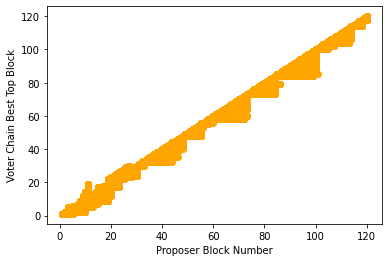

In [127]:
plt.scatter(proposerBlockNumbersArray, voterChainBestTopBlocksArray, c ="orange")
 
# To show the plot
plt.xlabel("Proposer Block Number")
plt.ylabel("Voter Chain Best Top Block")
plt.show()

In [128]:
proposerBlocksCoordinates = [[],[]]

with open(user_input, 'r') as f:
    for line in f:
        if "BENCHMARKING:" not in line:
            continue
        benchmarkSubstrings = line[line.find("BENCHMARKING"):-1].split(':')
        dateTimeString = line.split('[')[0][:-1]
        timestamp = getTimestamp(dateTimeString)
        event = benchmarkSubstrings[1]
        blockNumber = int(benchmarkSubstrings[3])
        if event == ProposerBlockMined or event == ValidProposerBlockDownloaded:
            proposerBlocksCoordinates[0].append(blockNumber)
            proposerBlocksCoordinates[1].append((timestamp-firstTimeStamp)/1000)
f.close()


voterChainsCoordinates = []
for i in range(0,100):
    voterChainsCoordinates.append([[],[]])

with open(user_input, 'r') as f:
    for line in f:
        if "VOTERCHAINHEALTH:" not in line:
            continue
        benchmarkSubstrings = line[line.find("VOTERCHAINHEALTH"):-1].split(':')
        dateTimeString = line.split('[')[0][:-1]
        timestamp = getTimestamp(dateTimeString)
        voterChainBestTopBlock = int(benchmarkSubstrings[4])
        voterChainIdx = int(benchmarkSubstrings[2])
        voterChainsCoordinates[voterChainIdx][0].append(voterChainBestTopBlock)
        voterChainsCoordinates[voterChainIdx][1].append((timestamp-firstTimeStamp)/1000)
f.close()

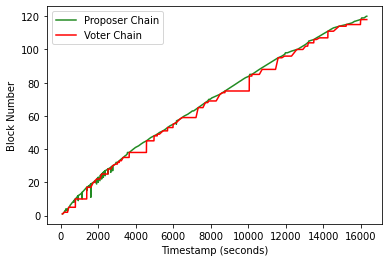

In [129]:
voterChainToSee = 42

plt.plot(proposerBlocksCoordinates[1], proposerBlocksCoordinates[0], c ="forestgreen", label="Proposer Chain")
plt.plot(voterChainsCoordinates[voterChainToSee][1], voterChainsCoordinates[voterChainToSee][0], c="red", label="Voter Chain") 
plt.legend(loc="upper left")

 
# To show the plot
plt.xlabel("Timestamp (seconds)")
plt.ylabel("Block Number")
plt.show()